# Project Milestone 2

In [ ]:
!pip install tld

In [ ]:
import pandas as pd
import numpy as np
import spacy
from joblib import Parallel, delayed

import time
from nltk import bigrams
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Utility functions

In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account
import json, os

# Google Cloud services
gcp_service_account_credentials_json_filename = 'epfl-course-f41b0ed796f9.json' #need to upload the json credential files to the root directory of the google colab files
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = gcp_service_account_credentials_json_filename
credentials = service_account.Credentials.from_service_account_file(gcp_service_account_credentials_json_filename, scopes=['https://www.googleapis.com/auth/bigquery', 'https://www.googleapis.com/auth/drive'])
project_id = 'epfl-course'
bigquery_client = bigquery.Client(credentials=credentials, project=project_id)
bigquery_client = bigquery.Client()

# Execute a query on Google BigQuery (BQ)
def bq_execute_query(query, mode="INTERACTIVE", wait=False, to_dataframe=False):
    job_config = bigquery.QueryJobConfig(priority="bigquery.QueryPriority.{}".format(mode)) # Run at BATCH priority, which won't count toward concurrent rate limit, otherwise INTERACTIVE.
    query_job = bigquery_client.query(query, job_config)
    if wait==True:
        print("Executed BQ query: ", query_job.result())
    if to_dataframe==True:
        return(query_job.to_dataframe())
    else:
        return(query_job)

# Upload a Dataframe to BQ
def upload_df_to_bq(df, bq_destination_table, write_disposition="WRITE_APPEND"):
    #bq_table_name = "epfl-course.dataset.table"
    job_config = bigquery.LoadJobConfig(create_disposition="CREATE_IF_NEEDED", write_disposition=write_disposition) #write_disposition="WRITE_TRUNCATE" in order to delete all the data from old table and insert new data
    upload_df_to_bq_job = bigquery_client.load_table_from_dataframe(
        df, bq_destination_table, job_config = job_config)
    print("Uploaded DF to BQ: ",upload_df_to_bq_job.result()) 

# Upload of JSON file to BQ
def upload_json_to_bq(json_object, bq_table):
    try:
        job_config = bigquery.LoadJobConfig()
        job_config.autodetect = False #Change to True if the table on BQ does not exits
        job_config.max_bad_records = 0
        job_config.ignore_unknown_values = True
        job_config.source_format = 'NEWLINE_DELIMITED_JSON'
        job_config.create_disposition= "CREATE_IF_NEEDED"
        job_config.write_disposition= "WRITE_APPEND"
        job_config.schema_to_json(schema_table)
        job = bigquery_client.load_table_from_file(json_object, bq_table, job_config = job_config)
        print("Loaded JSON to BQ table {} as job {}".format(bq_table, job.result()))
        assert job.job_type == 'load'
        assert job.state == 'DONE'
    except:
        print("ERROR Could not load JSON to BQ table {} as job {}".format(bq_table, job.result()))


## Loading data to BigQuery (BQ)

The files for this project are massive and are about 80Gb when uncompressed. It is essential to have a scalable solution that lets us:
- seemlessly query over the whole data in a scalable way
- visualize the data in tabular format
- present dashboard for the final project milestone

For these reasons we selected to use the Google suite of tools for large scale data warehouse (BigQuery) and dashboarding (DataStudio). Both of these tools are seemlessly integrated and it is an asset to work on this large scale data without having long loading or computing times.

To set this up, it is very convenient to use the best in calss APIs of Google Cloud Console. Once the credential file (private file, not part of this submission) put in the same directory than this notebook, the snippets above are ready to work!

The only challenge we encountered was the initial loading of the data as shown in the below snippets. The data had to be opened year by year, and within a year, batches of 100'000 lines were uploaded in order to be able to upload progressively the whole compressed JSON files and fit all that batch-wise in memory.

In [ ]:
from tld import get_tld
import bz2

def get_domain(url):
    res = get_tld(url, as_object=True)
    return res.tld

In [ ]:
# This is a special function to upload a dataframe to BQ for the pipeline since 
# the dataframe contains arrays that have to be ingested differently by BQ 
# for sequential file upload to be possible.

# Upload a DF to BQ
def upload_df_to_bq_initial_upload(df, bq_destination_table, write_disposition="WRITE_APPEND"):
    #bq_table_name = "epfl-course.dataset.table"
    job_config = bigquery.LoadJobConfig(create_disposition="CREATE_IF_NEEDED", 
                                        write_disposition=write_disposition,
                                        schema=[
                                            bigquery.SchemaField("quids", "STRING"),
                                            bigquery.SchemaField("probas", "STRING"),
                                            bigquery.SchemaField("urls", "STRING"),
                                            bigquery.SchemaField("domains", "STRING"),
                                        ])
    source_format=bigquery.SourceFormat.NEWLINE_DELIMITED_JSON
    upload_df_to_bq_job = bigquery_client.load_table_from_dataframe(
        df, bq_destination_table, job_config = job_config)
    print("Uploaded DF to BQ: ",upload_df_to_bq_job.result()) 

In [ ]:
# Main functions that perform the processing of the files and upload to BQ for all years (2015 to 2020).
# First, decompress the files and make smaller JSON files store on disk (each of 100'000 lines)
# Second, upload this file in BQ
# Third, remove the file from disk and continue to create and process the next file.

list_of_years_to_process = range(2015, 2020) #list of the years which data has to be send to Google BigQuery(BQ)

# Function uploads the JSON file to BQ and removes it from the disk to save storage
def upload_interim_file_to_bq(filename, year):
    print("uploading file: ", filename)
    df_to_upload = pd.read_json(filename, 
                                lines=True) #open file to upload to convert it from a JSON file to panda dataframe (df)
    bq_table = "epfl-course.ada_project.interim_data_{}".format(str(year))
    upload_df_to_bq_initial_upload(df_to_upload, 
                    bq_table) #upload the df to BQ !!table name as varible
    print("Uploaded df of shape: ", df_to_upload.shape)
    os.remove(filename) #remove the JSON file not to keep them on disk storage (since we are working on Google drive, disk storage is limited)

# Upload the data of one-year file to BQ
def upload_one_year_of_data(year):
    path_to_file = '/content/drive/MyDrive/EPFL HS21/Applied data analysis CS-401/Project/ADA team winner/Project Milestone 2/Quotebank/quotes-{}.json.bz2'.format(year)

    filename_out = 'quotes-{}-domains'.format(year)
    counter = 0
    number_of_rows_to_upload_per_batch = 100000 #reasonable threshold for file size upload to BQ (approx. 50mb per file uploaded)
    path_to_out_complete_previous = "" #a logical utility to compare the filename to the previous for-loop run
    with bz2.open(path_to_file, 'rb') as s_file:
        for instance in s_file: #iterates though every row of the 1-year file
            path_to_out_complete = filename_out + str(round(counter/number_of_rows_to_upload_per_batch)).zfill(10) + ".json" #filename of the file to be uploaded
            with open(path_to_out_complete, 'ab') as d_file: #open in append mode 'a' with binary encoding 'b'
                instance = json.loads(instance) # loading a sample
                urls = instance['urls'] # extracting list of links
                domains = []
                for url in urls:
                    tld = get_domain(url)
                    domains.append(tld)
                instance['domains'] = domains # updating the sample with domain name
                d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

                #logic that allows to upload data to BQ by batches of "number_of_rows_to_upload_per_batch" rows
                counter += 1
                if path_to_out_complete_previous == path_to_out_complete: #case where file to upload is not yet complete
                  pass
                elif path_to_out_complete_previous == "": #first iteration case
                  path_to_out_complete_previous = path_to_out_complete
                else: # case when the file is complete with enough data to be uploaded
                  upload_interim_file_to_bq(path_to_out_complete_previous, year)
                  path_to_out_complete_previous = path_to_out_complete
    upload_interim_file_to_bq(path_to_out_complete, year) #upload the last file for the year

# Upload data from all years
for year in list_of_years_to_process:
  print("Processing data for year: ", year)
  upload_one_year_of_data(year)

# DO NOT EXECUTE, THE DATA IS ALREADY IN THE CLOUD WAREHOUSE.
# UPLOADING WILL ONLY RESULT IN ADDING DUMMY DATA TO THE CLOUD.

## Downloading data from BQ

The snippet below shows how easy is it to download data, from our data warehouse in the cloud to this python notebook.
Users can freely make any query they want and have the result returned in a nicely formatted panda dataframe.

In [ ]:
# Upload data to Google BigQuery
# Adding a test query 
query = ''' select * from epfl-course.ada_project.quotes where date(date) = "2020-01-01" limit 5 '''
df = bq_execute_query(query, to_dataframe=True)
print(df.head())

             quoteID  ...                     domains
0  2020-01-01-015402  ...  {'list': [{'item': 'ca'}]}
1  2020-01-01-041913  ...  {'list': [{'item': 'ca'}]}
2  2020-01-01-007662  ...  {'list': [{'item': 'ca'}]}
3  2020-01-01-020596  ...  {'list': [{'item': 'ca'}]}
4  2020-01-01-012186  ...  {'list': [{'item': 'ca'}]}

[5 rows x 10 columns]


In [ ]:
print(df.columns)
print(df['quotation'].iloc[0])

Index(['quoteID', 'quotation', 'speaker', 'qids', 'date', 'numOccurrences',
       'probas', 'urls', 'phase', 'domains'],
      dtype='object')
I'd love consumers to embrace wholesome seasonal produce and get cooking with their families and communities.


## Initial analysis on the data and its completeness

The code section below aims at analysing the quality of the data (e.g. missing values, duplicates, lemmatization accuracy,...).

Overall, the analysis shows that the data is of high quality and that we can trust it for further processing.
Some data inclusion and processing guidelines are provided for project Milestone 3.

In [ ]:
# How many quotes have missing values in the base data?

# the following query analyses if the uploaded data present in the BQ warehouse
# is actually of quality and does not contain any missing data
query_empty_values_in_raw_data_table = ''' 
  SELECT
    COUNT(quoteID) AS count_total,
    COUNTIF(quotation IS NULL) AS quotation_null,
    COUNTIF(speaker IS NULL) AS speaker_null,
    COUNTIF(qids IS NULL) AS qids_null,
    COUNTIF(date IS NULL) AS date_null,
    COUNTIF(numOccurrences IS NULL) AS numOccurrences_null,
    COUNTIF(probas IS NULL) AS probas_null,
    COUNTIF(urls IS NULL) AS urls_null,
    COUNTIF(phase IS NULL) AS phase_null,
    COUNTIF(domains IS NULL) AS domains_null,
    #COUNTIF(ARRAY_LENGTH(domains.list) =0) AS domains_null,
  FROM
    `epfl-course.ada_project.quotes` '''

# Execute the BQ query and return the result as a dataframe
df_empty_values_in_raw_data_table = bq_execute_query(query_empty_values_in_raw_data_table, to_dataframe=True)
df_empty_values_in_raw_data_table

,count_total,quotation_null,speaker_null,qids_null,date_null,numOccurrences_null,probas_null,urls_null,phase_null,domains_null
0,115547792,0,0,0,0,0,0,0,0,0


Out of the 115547792 quotes in the whole dataset (years 2015 to 2020) there are no missing values in any of the columns. This means that out base "raw data" is of high quality and that we can trust it regarding missing data for further data analysis.

In [ ]:
# Are there some duplicates in the quotes (across all years)?

# The following query checks if any of the quoteIDs is duplicate in the row data
query_duplicate_quotes = ''' 
  WITH
    duplicate_count AS (
    SELECT
      COUNT(quoteID) AS count_ids_per_quoteid,
    FROM
      `epfl-course.ada_project.quotes`
    GROUP BY
      quoteID)
  SELECT
    COUNTIF(count_ids_per_quoteid > 1) AS duplicate_count
  FROM
    duplicate_count'''

df_duplicate_quotes = bq_execute_query(query_duplicate_quotes, to_dataframe=True)
print("Duplicate quotes in the whole dataset (years from 2015 to 2020: ", int(df_duplicate_quotes['duplicate_count']))

Duplicate quotes in the whole dataset (years from 2015 to 2020:  0


A simple count on the quoteID column shows that there are no duplicates in the data.

In [ ]:
# How many quotes did not receive any lemma? (in January 2019)

query_quotes_without_lemmas = ''' 
  WITH
    anomaly_count AS (
    SELECT
      COUNT(quoteid) AS total_count_of_quotes,
      COUNTIF(ARRAY_LENGTH(lemmats.list) = 0) AS quotes_without_lemmas,
    FROM
      `epfl-course.ada_project.quote_preprocessed_arrays`)
  SELECT
    *,
    quotes_without_lemmas/total_count_of_quotes AS quotes_without_lemma_ratio,
  FROM
    anomaly_count '''

df_quotes_without_lemmas = bq_execute_query(query_quotes_without_lemmas, to_dataframe=True)
print("Analysis for January 2019")
print("total_count_of_quotes: ", int(df_quotes_without_lemmas['total_count_of_quotes']))
print("quotes_without_lemmas: ", int(df_quotes_without_lemmas['quotes_without_lemmas']))
print("quotes_without_lemma_ratio: ", df_quotes_without_lemmas['quotes_without_lemma_ratio'][0])

Analysis for January 2019
total_count_of_quotes:  1922273
quotes_without_lemmas:  2305
quotes_without_lemma_ratio:  0.0011991012722958705


We can see that there are some quotes on which our models did not retrieve any lemmas. These quotes do not contain any keyword and are chained random words rather than full understandable sentences.
In January 2019, 2305 quotes out of 1922273 total quotes (approx. 0.12%) did not receive any lemma after the lemmatization. We will discard these quotes for futher analysis.

In [ ]:
# How many quotes have non-English lemmas?

# This query will compute for each quote, 
# what is the proportion of non-English characters 
# across all lemmas copared to the number of characters 
# in the quote itself. See method explanation below.
query_non_english_lemmas = ''' 
    WITH
    replaced_quotations AS (
    SELECT
      quoteid,
      lemmats AS quotation,
      REGEXP_REPLACE(lemmats, r'[a-zA-Z0-9’., %`$. -:,;+#™!?]', '') AS replaced,
      #list of characters that we consider to be regular part of english quotes
    FROM
      `epfl-course.ada_project.quote_preprocessed`),
    quotes_with_non_english_ratio AS (
    SELECT
      *,
      LENGTH(replaced)/LENGTH(quotation) AS non_english_ratio,
    FROM
      replaced_quotations
    WHERE
      LENGTH(replaced) != 0),
    non_english_quotes AS (
    SELECT
      *,
    FROM
      quotes_with_non_english_ratio
    WHERE
      non_english_ratio >= .04 # above or equal to .04 the quotation is considered non-english or trash
    ORDER BY
      non_english_ratio asc)
  SELECT
    quoteid,
    quotation,
    non_english_ratio,
  FROM
    non_english_quotes '''

df_non_english_lemmas = bq_execute_query(query_non_english_lemmas, to_dataframe=True)
print("Non english quotes for January 2019 (above ratio of .04): ", len(df_non_english_lemmas['non_english_ratio']))

Non english quotes for January 2019 (above ratio of .04):  1101


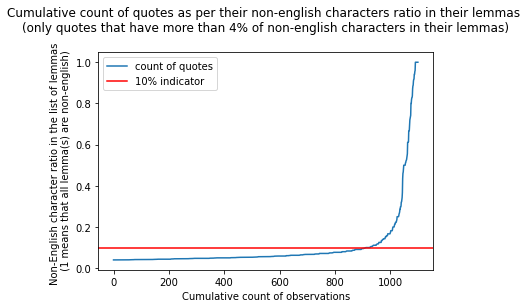

In [ ]:
# Plotting the result of the previous query in a visual chart
plt.plot(df_non_english_lemmas.non_english_ratio, label="count of quotes")
plt.axhline(y=0.1, color='r', linestyle='-', label="10% indicator")
plt.title("Cumulative count of quotes as per their non-english characters ratio in their lemmas \n(only quotes that have more than 4% of non-english characters in their lemmas)\n")
plt.xlabel("Cumulative count of observations")
plt.ylabel("Non-English character ratio in the list of lemmas \n (1 means that all lemma(s) are non-english)")
plt.legend()

Our model lemmatized all the quotes of January 2019 so far. So of them were not in English or were not in another alphabet.
We found out that there are 1101 quotes that have non english lemmas out of 1922273 (approx. 0.06%) of the lemmatized quotes. Since these quotes are a marginal portion of the dataset and meaningless for our analysis, we will discard them for the rest of the analysis.

**Detecting non english quotes** 
In order to detect non-english language quotes, we tried to found out which quotes were not of english alphabet. To do this, we selected a list of characters that count as being part of the english language, and all the rest is considered to be a non-english language. The following list is in regex format: [a-zA-Z0-9’., %`$. -:,;+#™!?]
The analysis was run in the following order:
1. remove from the quotes all the english alphabet characters from the above list (after this operation, a full english text quote should return an empty string since all of its elements would have been removed)
2. for all the strings that have remaing non-english text characters, count of much of the original quote proportion of remaining characters represent. If the length of remaining characters is more than 4% of the length of the original quote, we consider the quote to either of poor quality (too many symbols and emojis for instance), non english text (composed of too many non-english text characters) or too technical (composed of too many symbols which indicates that the quote looks more like a mathematical formula than english text).

Non english quotes for January 2019 (above ratio of .04):  5976


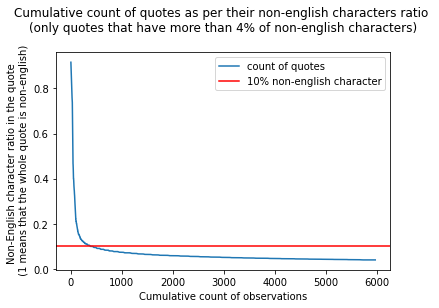

In [ ]:
#How many quotes are not english?

query_non_english_quotes = ''' 
      WITH
    replaced_quotations AS (
    SELECT
      quoteid,
      quotation,
      REGEXP_REPLACE(quotation, r'[a-zA-Z0-9’., %`$. -:,;+#™!?]', '') AS replaced,
      #list of characters that we consider to be regular part of english quotes
    FROM
      `epfl-course.ada_project.quotes_2019_january`),
    quotes_with_non_english_ratio AS (
    SELECT
      *,
      LENGTH(replaced)/LENGTH(quotation) AS non_english_ratio,
    FROM
      replaced_quotations
    WHERE
      LENGTH(replaced) != 0),
    non_english_quotes AS (
    SELECT
      *,
    FROM
      quotes_with_non_english_ratio
    WHERE
      non_english_ratio >= .04 # above or equal to .04 the quotation is considered non-english or trash
    ORDER BY
      non_english_ratio DESC)
  SELECT
    quoteid,
    non_english_ratio,
  FROM
    non_english_quotes '''

df_non_english_quotes = bq_execute_query(query_non_english_quotes, to_dataframe=True)
print("Non english quotes for January 2019 (above ratio of .04): ", len(df_non_english_quotes['non_english_ratio']))

# Plotting the result of the previous query in a visual chart
plt.plot(df_non_english_quotes.non_english_ratio, label="count of quotes")
plt.axhline(y=0.1, color='r', linestyle='-', label="10% non-english character")
plt.title("Cumulative count of quotes as per their non-english characters ratio \n(only quotes that have more than 4% of non-english characters)\n")
plt.xlabel("Cumulative count of observations")
plt.ylabel("Non-English character ratio in the quote \n (1 means that the whole quote is non-english)")
plt.legend()

In the previous plot for can see that 5976 quotes were detected as non-English text by our previously described method. This is approximately 0.31% of the 1922273 quotes for January 2021.
Since this data is meaningless for our analysis and is only a marginal portion of the whole dataset, we will drop these quotes for the rest of the analysis.



In [ ]:
# The same non-English quote analysis but on all data from all years (2015 to 2020)
query_non_english_quotes_all_years = ''' 
  WITH
    replaced_quotations AS (
    SELECT
      quoteid,
      quotation,
      REGEXP_REPLACE(quotation, r'[a-zA-Z0-9’., %`$. -:,;+#™!?]', '') AS replaced,
      #list of characters that we consider to be regular part of english quotes
    FROM
      `epfl-course.ada_project.quotes_2019`),
    quotes_with_non_english_ratio AS (
    SELECT
      *,
      LENGTH(replaced)/LENGTH(quotation) AS non_english_ratio,
    FROM
      replaced_quotations
    WHERE
      LENGTH(replaced) != 0),
    non_english_quotes AS (
    SELECT
      *,
    FROM
      quotes_with_non_english_ratio
    WHERE
      non_english_ratio >= .04 # above or equal to .04 the quotation is considered non-english or trash
    ORDER BY
      non_english_ratio DESC),
    count_of_quotes_without_ratio AS (
    SELECT
      COUNT(all_quotes.quoteID) AS all_quotes_count,
      COUNTIF(non_english_quotes.quoteid IS NOT NULL) AS non_english_quotes_all_years,
    FROM
      `epfl-course.ada_project.quotes_2019` AS all_quotes
    LEFT JOIN
      non_english_quotes
    USING
      (quoteid))
  SELECT
    *,
    non_english_quotes_all_years/all_quotes_count AS non_english_quotes_ratio,
  FROM
    count_of_quotes_without_ratio '''

non_english_quotes_all_years = bq_execute_query(query_non_english_quotes_all_years, to_dataframe=True)
print("Count of quotes for all years (2015 to 2020): ", int(non_english_quotes_all_years['all_quotes_count']))
print("Non-English quotes for all years (2015 to 2020): ", int(non_english_quotes_all_years['non_english_quotes_all_years']))
print("Non-English quotes ratio for all years (2015 to 2020): {}%".format(round(non_english_quotes_all_years['non_english_quotes_ratio'][0]*100, 2)))


Count of quotes for all years (2015 to 2020):  21763302
Non-English quotes for all years (2015 to 2020):  67563
Non-English quotes ratio for all years (2015 to 2020): 0.31%


Running the analysis on all the data (years 2015 to 2020) shows that 67563 (0.31%) of the data can be considered as non-english text. We will discard these quotes for the rest of the analysis.

The data that has been recommended to be removed from the analysis, will be removed for all analysis in the project 3 milestone.

# Language preprocessing and extracting geographical names from quotes

In [ ]:
# Tip for quicker processing https://prrao87.github.io/blog/spacy/nlp/performance/2020/05/02/spacy-multiprocess.html#Read-in-New-York-Times-Dataset
nlp = spacy.load("en_core_web_sm")
all_stopwords = nlp.Defaults.stop_words

def lemmatize_and_get_geo_pipe(doc):
    
    # Perform lemmatization and stopword removal in the clean text.
    # Extract named entities labeled as "GPE" - Geo Political Entities by spacy
    # Returns a list of lemmas and a list of GPEs

    lemma_list = [str(tok.lemma_).lower() for tok in doc
                  if tok.is_alpha and tok.text.lower() not in all_stopwords]  
    
    geo_tokens = [ent.text for ent in doc.ents if ((ent.label_ == "GPE"))] 
    return lemma_list, geo_tokens

def chunker(iterable, total_length, chunksize): 
    # Divide the rows into chunks for batch processing
    return (iterable[pos: pos + chunksize] for pos in range(0, total_length, chunksize))

def flatten(list_of_lists):
    "Flatten a list of lists to a combined list"
    return [item for sublist in list_of_lists for item in sublist]

def process_chunk(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=20): # using spacy pipes to process the data more efficiently
        preproc_pipe.append(lemmatize_and_get_geo_pipe(doc))
    return preproc_pipe

# Executing the processing on multiple threads
def preprocess_parallel(texts, chunksize=100, fun=process_chunk):
    executor = Parallel(n_jobs=7, backend='multiprocessing', prefer="processes")
    do = delayed(process_chunk)
    tasks = (do(chunk) for chunk in chunker(texts, len(df), chunksize=chunksize))
    result = executor(tasks)
    return flatten(result)

We are running the initial analisis first on quotes only from January 2019.



In [ ]:
query_january_2019 = "select quoteId, quotation from epfl-course.ada_project.quotes_2019_january limit 10"
# For language processing I only need to extract a quote id and the content of the quote
# for testing added "limit 10" at end of query
df = bq_execute_query(query_january_2019, to_dataframe=True)
df.head()

,quoteId,quotation
0,2019-01-13-042492,the benefits of experiencing healthy doses of ...
1,2019-01-13-035706,our culture today is obsessively focused on un...
2,2019-01-13-035809,"Our goaltender's on fire right now,"
3,2019-01-13-002608,And I have to say I'm not entirely surprised b...
4,2019-01-13-052629,Turnitin is not pedagogical. Turnitin is polic...


In [ ]:
# Query read a given month from the dataset
# We will process the dataset a month at a time due to colab limitations,
# the computational cost and memory limitations
# The query is commented out for now to avoid accidentaly making expensive BQ queries
month = 1 # Providing month as a number
years = 2020
#query = "select quoteId, quotation from epfl-course.ada_project.quotes where extract(year from date) = {} and extract(month from date) = {}".format(year, month)

In [ ]:
df['geoNames_lemmas'] = preprocess_parallel(df['quotation'], chunksize=1000)
df.head()

,quoteId,quotation,geoNames_lemmas
0,2019-01-13-042492,the benefits of experiencing healthy doses of ...,"([benefit, experience, healthy, dose, pain], [])"
1,2019-01-13-035706,our culture today is obsessively focused on un...,"([culture, today, obsessively, focus, unrealis..."
2,2019-01-13-035809,"Our goaltender's on fire right now,","([goaltender, fire, right], [])"
3,2019-01-13-002608,And I have to say I'm not entirely surprised b...,"([entirely, surprised, get], [])"
4,2019-01-13-052629,Turnitin is not pedagogical. Turnitin is polic...,"([turnitin, pedagogical, turnitin, police, int..."


In [ ]:
df[['lemmats', 'geoNames']] = pd.DataFrame(df['geoNames_lemmas'].tolist(), index=df.index)
df=df.drop(['quotation', 'geoNames_lemmas'], axis = 1)
df.head()

,quoteId,lemmats,geoNames
0,2019-01-13-042492,"[benefit, experience, healthy, dose, pain]",[]
1,2019-01-13-035706,"[culture, today, obsessively, focus, unrealist...",[]
2,2019-01-13-035809,"[goaltender, fire, right]",[]
3,2019-01-13-002608,"[entirely, surprised, get]",[]
4,2019-01-13-052629,"[turnitin, pedagogical, turnitin, police, inte...",[]


In [ ]:
len(df[df["geoNames"].map(lambda d: len(d)) > 0].index)

220691

In [ ]:
upload_df_to_bq(df, 'epfl-course.ada_project.quote_preprocessed_arrays')

In [ ]:
# Testing to see if I can read back the dataframe from BQ
query_verificating_processed= "select * from epfl-course.ada_project.quote_preprocessed_arrays limit 10"
df_verification = bq_execute_query(query_verificating_processed, to_dataframe=True)
df_verification.head()

,quoteId,lemmats,geoNames
0,2019-01-26-014239,"{'list': [{'item': 'celebrate'}, {'item': 'pag...",{'list': [{'item': 'Ottawa'}]}
1,2019-01-26-012258,"{'list': [{'item': 'great'}, {'item': 'backgro...",{'list': [{'item': 'Calgary'}]}
2,2019-01-26-008827,"{'list': [{'item': 'earthquake'}, {'item': 'ot...",{'list': [{'item': 'Ottawa'}]}
3,2019-01-26-035887,"{'list': [{'item': 'course'}, {'item': 'canada...","{'list': [{'item': 'Canada'}, {'item': 'the Un..."
4,2019-01-26-043816,"{'list': [{'item': 'ascendance'}, {'item': 'ch...",{'list': [{'item': 'China'}]}


For milestone 1 the data for January 2019 is processed. We will be progressively running the pipeline for the rest of the dataset. 

# Calculating daily Unigram and Bigram Frequencies

Here we pull the processed data (calculated above) from Big Query (if necessary)

In [ ]:
# WARNING this query takes 12/13 minutes. We are still testing out the best way to store the data in Big Query
#query = "select quoteId, lemmats from epfl-course.ada_project.quote_preprocessed_arrays"
#df= bq_execute_query(query, to_dataframe=True)

#df['date'] = pd.to_datetime(df['quoteId'].str.slice(0,10))

In [ ]:
### Only 2.5 minutes
query = "select quoteId, lemmats from epfl-course.ada_project.quote_preprocessed"
df = bq_execute_query(query, to_dataframe=True)
df = df[~df['lemmats'].isna()]
df['date'] = pd.to_datetime(df['quoteId'].str.slice(0,10))

Now we calculate the ngram frequencies. We first tried using a purely pandas method, but it can crash the runtime sometimes. It is also much slower

In [ ]:
def bq_array_to_list(bq_array):
    out = []
    for item in bq_array['list']:
        out += [item['item']]
    return out

def pd_word_freq(df):
    t1 = time.time()
    #We only want to keep the date and lemmats
    df_word = df.drop(columns=['quoteId','geoNames'])
    #Split and get unique words in each quote. We want the number of quotes a word has appeared in, not the
    #total number of times a word has appeared.
    df_word['lemmats'] = df_word['lemmats'].str.split().apply(set).apply(list)
    t2 = time.time()
    print(f'Time taken to split and get unique values: {(t2-t1):.2f}s')
    
    #Group by the date and count the number of occurences
    df_group = df_word.explode('lemmats').groupby(by='date')
    df_group = pd.DataFrame(df_group['lemmats'].value_counts())
    
    #Get data frame to look nice
    df_counts = df_group.rename(columns={'lemmats':'count'})
    df_counts = df_counts.reset_index()
    t3 = time.time()
    print(f'Time taken group and count by date: {(t3-t2):.2f}s')
    print(f'Total time taken: {(t3-t1):.2f}s')
    
    return df_counts
#pd_word_freq(df.copy())

Here we manually go over each day and calculate the counts, which is about x2 faster

In [ ]:

def word_frequency(df, days=1, bigram=False, threshold=2):

    t1 = time.time()
    #Split the lemmats and apply bigram
    df['lemmats'] = df['lemmats'].str.split()
    if bigram:
        df['lemmats'] = df['lemmats'].apply(bigrams).apply(list)
    t2 = time.time()
    print(f'Time take to split and apply bigram: {(t2-t1):.2f}s.')
    df = df.sort_values(by='date', ascending=True)    
    
    current_date = df['date'].min()
    end_date = df['date'].max()
    offset = pd.DateOffset(days=days)
    
    #Iterate over the days
    count_list = []
    while current_date <= end_date:
        print(f'Counting over date: {current_date}',end='\r')
        #Get quotes from current day
        date_index = (df['date'] >= current_date) & (df['date'] < (current_date+offset))
        date_quotes = df['lemmats'][date_index]
        
        #Append words that have appeared. We first apply set to get the unique values,
        # and then list so that we can count the number of quotes each word has appeared in
        unique_word_list = []
        for row in date_quotes:
            unique_word_list += list(set(row))

        #Get counts and save to dataframe
        counts = pd.Series(unique_word_list).value_counts()
        count_df = pd.DataFrame(counts).reset_index()
        count_df['date']=[current_date]*len(counts)
        count_df = count_df.loc[:,['date','index',0]].rename(columns={'index':'word',0:'count'})
        count_list.append(count_df)
        
        current_date += offset
    t3 = time.time()
    print()
    print(f'Time taken to get daily word counts: {(t3-t2):.2f}s')

    count_df = pd.concat(count_list, axis=0)
    if bigram:
        count_df = count_df[count_df['count']>threshold]
        count_df[['word1','word2']] = pd.DataFrame(count_df['word'].tolist(), index= count_df.index)
        count_df = count_df.drop('word', axis=1)
    print(f'Total time taken: {(t3-t1):.2f}s')
    return count_df
counts = word_frequency(df.copy(), days=1)
counts

Time take to split and apply bigram: 8.97s.

Time taken to get daily word counts: 11.38s
Total time taken: 20.35s


,date,word,count
0,2019-01-01,year,2720
1,2019-01-01,go,2474
2,2019-01-01,think,2339
3,2019-01-01,people,2263
4,2019-01-01,good,2246
...,...,...,...
38549,2019-01-31,walkin,1
38550,2019-01-31,indep,1
38551,2019-01-31,harborne,1
38552,2019-01-31,hov,1


Now we get the bigram frequencies, and apply a threshold since there are about 10 million bigrams with only 1 or 2 frequencies

In [ ]:
#Get bigram frequencies
#### IF a 'generator' error appears you need to update nltk to 3.4
# !pip install nltk==3.4
bigram_counts = word_frequency(df.copy(),bigram=True, threshold=2)
bigram_counts

Time take to split and apply bigram: 39.35s.

Time taken to get daily word counts: 48.14s
Total time taken: 87.49s


,date,count,word1,word2
0,2019-01-01,624,new,year
1,2019-01-01,266,little,bit
2,2019-01-01,233,feel,like
3,2019-01-01,179,look,forward
4,2019-01-01,175,happy,new
...,...,...,...,...
43313,2019-01-31,3,big,red
43314,2019-01-31,3,heat,go
43315,2019-01-31,3,definitely,easy
43316,2019-01-31,3,price,affordable


Text(0.5, 1.0, 'Bigram counts and their frequencies')

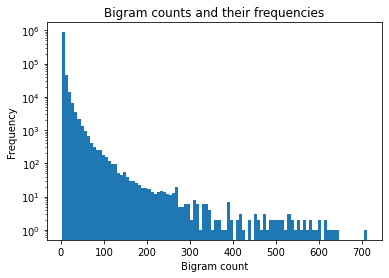

In [ ]:
#Visualise bigram frequency distribtuion. We can get rid of low occurence bigrams to
#make the dataset smaller
#bigram_counts.plot.hist('count',bins=100, log=True)
plt.hist(bigram_counts['count'], bins=100, log=True);
plt.xlabel('Bigram count')
plt.ylabel('Frequency')
plt.title('Bigram counts and their frequencies')

# Analysing spikes in January 2019

Now we can analyse hotwords by finding spikes in their frequencies. However, one of the first things we noticed is that there are many more quotes during the weekday compared to the weekend, which will affect how our hotwords will be found. This can be seen in the following plot

Text(0.5, 1.0, 'Total number of quotations per Day in January')

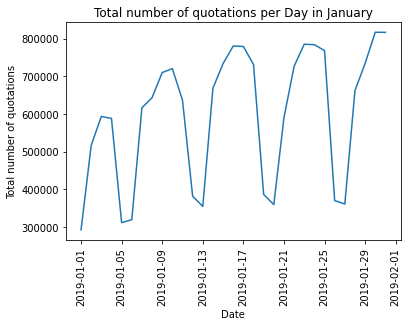

In [ ]:
total_daily_quotes = counts.drop(columns=['word']).groupby(by='date').sum().reset_index()
#total_daily_quotes.plot(x='date',y='count', xlabel='Date',ylabel='Total number of quotations', 
#                        title='Total number of quotations per Day in January')

### Pandas was doing some weird stuff with the date xticks so just using matplot
plt.plot(total_daily_quotes['date'], total_daily_quotes['count'])
plt.xticks(rotation='vertical')
plt.xlabel('Date')
plt.ylabel('Total number of quotations')
plt.title('Total number of quotations per Day in January')


Because of this seasonality, we decided to apply a 7 day moving average to each word count to smooth out the curve. This is done using an SQL query since it makes things much easier.

In [ ]:
query = """ WITH quote_count AS (SELECT DISTINCT(LEFT(quoteId, 10)) AS date,
                COUNT(LEFT(quoteId, 10)) AS daily_quote_count,
                FROM `epfl-course.ada_project.quote_preprocessed`
                GROUP BY date)

            SELECT *, AVG(daily_quote_count) OVER(ORDER BY UNIX_DATE(DATE(date)) 
                ASC RANGE BETWEEN 6 PRECEDING AND CURRENT row) AS daily_quotes_moving_average
            FROM quote_count"""
moving_avg_df = bq_execute_query(query, to_dataframe=True)

Text(0.5, 1.0, '7 day moving average over number of daily quotations in January')

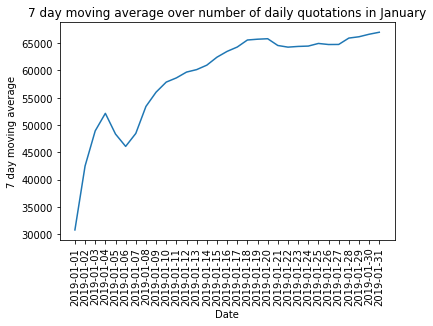

In [ ]:
dates = moving_avg_df['date']
moving_avg = moving_avg_df['daily_quotes_moving_average']
plt.plot(dates, moving_avg)
plt.xticks(rotation='vertical')
plt.xlabel('Date')
plt.ylabel('7 day moving average')
plt.title('7 day moving average over number of daily quotations in January')


Since for now we have only processed the month of January, the moving average has smoothed the counts too much. This makes it hard to find clear hot words. We think once we have the 5 year processed data this issue will disappear, so for now we will just analyse the raw word counts.

Lets start with Trump. There are 2 interesting things from the graph below. Firstly, each spike corresponds nicely with controversies that Trump had over the month of January in 2019, as can be seen [here](https://en.wikipedia.org/wiki/Timeline_of_the_Donald_Trump_presidency_(2019_Q1)). For example, the major spike on January 9th corresponds to the day Trump walked out on a meeting with democrats. The second interesting thing is that both words have the same distribution, which implies that the majority of the time that the word 'president' is mentioned it is refering to 'trump', as we will show next.

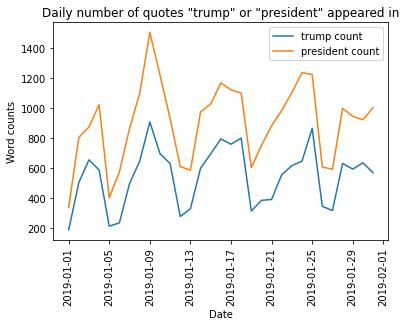

In [ ]:
trump_ind = counts['word'] == 'trump'
pres_ind = counts['word'] == 'president'

plt.plot(counts['date'].unique(), counts['count'][trump_ind])
plt.plot(counts['date'].unique(), counts['count'][pres_ind])
plt.xticks(rotation='vertical')
plt.xlabel('Date')
plt.ylabel('Word counts')
plt.title('Daily number of quotes "trump" or "president" appeared in')
plt.legend(['trump count', 'president count'])


#df['lemmats'][date_ind & trump_ind & keywords]#.str.contains('walk|democrat|meeting')

Here we can see that Trump and Donald appear the most often after president. There are some other presidential names, but the majority are useless words like 'think', 'need', 'know', etc...

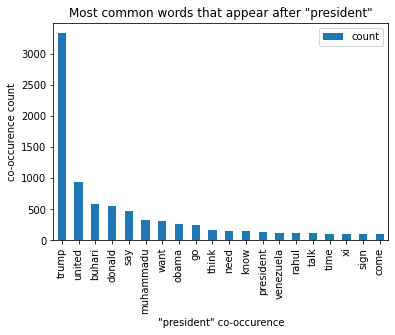

In [ ]:
president_cooccurence = bigram_counts[bigram_counts['word1']=='president'].groupby('word2').sum().reset_index()
president_cooccurence = president_cooccurence.sort_values('count',ascending=False)
president_cooccurence[0:20].plot.bar(x='word2',y='count', xlabel='"president" co-occurence', 
                                     ylabel='co-occurence count', 
                                     title='Most common words that appear after "president"')

## Topic finding
In this part we run a preliminary topic finding analysis on the dataset. Our aim for the project is to use **Latend Dirichlet Allocarion** (LDA), an unsupervised learning algorithm, to associate each quote to a topic.

For the project we intend to train the topic model on a subset of the data (a month) and use the it to identify topics in the whole dataset. In the following we perform a preliminary analysis on just the first week of 2019



In [ ]:
from nltk.stem import *
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.test.utils import datapath
from gensim.models import LdaModel
import nltk
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

We first get the data from BQ

In [ ]:
#getting the first 7 days of data from BQ
query = ''' select * from epfl-course.ada_project.quotes_2019_january where date(date) between "2019-01-01" and "2019-01-07" '''
df = bq_execute_query(query, to_dataframe=True)

In the following 3 cells we format the quotes in an appropriate way for the LDA algorithm to be trained. LDA uses bag of words embedding, so we need to tokienize, lemmatize and stem the words. Then we need to remove hotwords and apply the bag of words embedding. In *bag-of-words-embedding*, quotes are represented with a list of tuples of the kind (index, count), where index is an index that uniquely indentifies a token in the corpus and count is the number of times it appears in the quote.

In [ ]:
#stem and lemmatize
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
nltk.download('wordnet')

#lemmatizes aand stems the words
def stem_lematize(text):
  res = lemmatizer.lemmatize(text, pos = 'v')
  res = stemmer.stem(res)
  return res

#converts the words text in a list
def preprocess(text):
  result=[]
  for token in gensim.utils.simple_preprocess(text) :
      if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
          result.append(stem_lematize(token))
              
  return result

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#preprocess everything 
processed_quotes = []
for s in df['quotation'].values:
  processed_quotes += [preprocess(s)]
dictionary = gensim.corpora.Dictionary(processed_quotes)
corpus = [dictionary.doc2bow(doc) for doc in processed_quotes]

LDA is an unsupervised learning algorithm, but it takes, as input, the number of topics to be found. OF course we do not know such number, so we trained many madels with different number of topics and selected the one with the best performances ( we used *coherence* to copmute the accuracy ). 

For the project we might vary more parameters (like the number of passess) as well as using more sophisticated strategies ( like using a validation set) to perform this part.

In [ ]:
#perform a grid search of the number of topics
num_topics = [5, 10, 15]
models=[]
coherence_value = []
for n in num_topics:
  lda_model =  gensim.models.LdaMulticore(corpus, 
                                    num_topics = n, 
                                    id2word = dictionary,                                    
                                    passes = 10)
  models.append(lda_model)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_quotes, dictionary=dictionary, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  coherence_value.append(coherence_lda)
  print("number of topics ",n,"coherence_value :" , coherence_lda)

number of topics  5 coherence_value : 0.3567616431336858
number of topics  10 coherence_value : 0.41129863627628216
number of topics  15 coherence_value : 0.47081682731239477


In [ ]:
num_topics = [20, 25, 30, 35]
for n in num_topics:
  lda_model =  gensim.models.LdaMulticore(corpus, 
                                    num_topics = n, 
                                    id2word = dictionary,                                    
                                    passes = 10)
  models.append(lda_model)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_quotes, dictionary=dictionary, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  coherence_value.append(coherence_lda)
  print("number of topics ",n,"coherence_value :" , coherence_lda)


number of topics  20 coherence_value : 0.45617435853924276
number of topics  25 coherence_value : 0.446493332592534
number of topics  30 coherence_value : 0.4184232276416095
number of topics  35 coherence_value : 0.4041009277009659


In [ ]:
#refining the search
for n in range(8, 12):
  lda_model =  gensim.models.LdaMulticore(corpus, 
                                    num_topics = n, 
                                    id2word = dictionary,                                    
                                    passes = 10)
  models.append(lda_model)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_quotes, dictionary=dictionary, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  coherence_value.append(coherence_lda)
  print("number of topics ",n,"coherence_value :" , coherence_lda)

number of topics  8 coherence_value : 0.5072056404898615
number of topics  9 coherence_value : 0.5123495576732852
number of topics  10 coherence_value : 0.48951417512951345
number of topics  11 coherence_value : 0.5003972596339666


We pick the best model and save it to (and then load it from) a file. This is just to prove that we can have a fixed model that we can use on the whole dataset without training a new one each time.

In [ ]:
# Save best model to disk.
temp_file = datapath("model")
models[-3].save("model.txt")

In [ ]:
#load the model from file
lda_model = LdaModel.load("model.txt")

The remaining part is for the visualization of the results.

For instance, the first 3 topics found are:

1.   **SPORT** 
2.   **POLITICS**
3.   **ECONOMICS/BUSINNESS**

In the following we group the quotes according with what our model predicts (with a probability > 0.9) and we plot a "CloudOfWords" for the first 3 topics we found. Below the plot, we also print the *Model Hot Words*, i.e. the most representative words for the given topic with their corresponding weights (how much important they are).


In [ ]:
def assess_group(topic):
  indices_group_1 = []
  for i in range(len(processed_quotes)):
    prediction = np.array(lda_model[corpus[i]])[:, 1]
    predicted_class = np.argmax(prediction)
    if predicted_class == topic and prediction[predicted_class] > 0.9:
      indices_group_1 += [i]
  dataset_words=''.join(list(str(df['quotation'].values[indices_group_1])))
  print(type(dataset_words))
  wordcloud = WordCloud(width = 800, height = 500, 
                  background_color ='white',  
                  min_font_size = 10).generate(dataset_words) 

  plt.figure(figsize = (5, 5), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
    
  plt.show() 

  print('Model hot words')
  print(lda_model.print_topic(topic))
  return wordcloud, indices_group_1

<class 'str'>


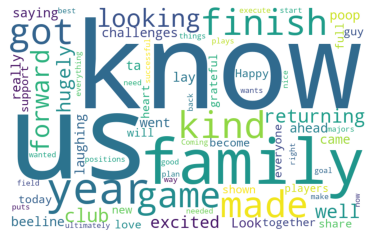

Model hot words
0.034*"play" + 0.026*"team" + 0.025*"good" + 0.022*"game" + 0.017*"think" + 0.015*"player" + 0.015*"go" + 0.015*"great" + 0.013*"year" + 0.013*"best"
<class 'str'>


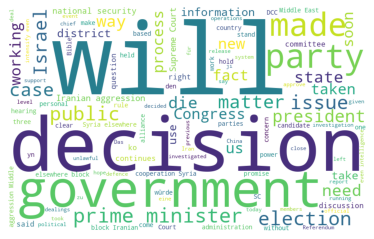

Model hot words
0.017*"govern" + 0.017*"state" + 0.010*"issu" + 0.010*"case" + 0.009*"parti" + 0.009*"elect" + 0.008*"polit" + 0.007*"deal" + 0.007*"decis" + 0.006*"offic"
<class 'str'>


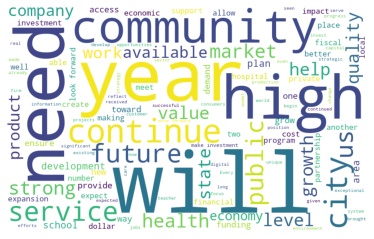

Model hot words
0.012*"year" + 0.009*"need" + 0.009*"work" + 0.009*"market" + 0.008*"develop" + 0.008*"busi" + 0.008*"compani" + 0.008*"continu" + 0.008*"provid" + 0.008*"money"


In [ ]:
results = [assess_group(topic) for topic in range(0, 3)] 

We can also look at the quotes to make sure that they are coherently about a given topic.

SOME QUOTES IN THE TOPIC **SPORT**:

In [ ]:
for q in df['quotation'].values[results[0][1]][:5]:
  print(q)

Mark is going well but was rested for the last Heat game while Delissa is so much better with the ball after have some time out of the game,
It's been a really fun week getting ready. It's a great time of year to be playing football,
He's taken this club to the next level after it had had been trying to reach the Premier League for a long time,
We had a really good first race together as a new team, and it was a proud moment to watch everything come together during the race weekend,
For the next six months he will be with Borussia, but I'm happy that we are getting young players. Hopefully, he can be very good for us.


SOME QUOTES IN THE TOPIC **POLITICS**:

In [ ]:
for q in df['quotation'].values[results[1][1]][:5]:
  print(q)

Our effort to counter Iranian aggression continues, and our commitment to... the protection of Israel continues in the same way as before that decision was made,
intensify even further our intelligence and operations cooperation in Syria and elsewhere to block Iranian aggression in the Middle East.
buttressed with substantive reforms in governance and oversight regime, supported by recapitalisation of weak PSBs
discuss how to even deepen the intelligence and operational cooperation [ between the US and Israel ] in Syria and other places
I call on all leftists to join Meretz to lead the leftist bloc in the coming elections.


SOME QUOTES IN THE TOPIC **ECONOMICS/BUSINNESS**:

In [ ]:
for q in df['quotation'].values[results[2][1]][:5]:
  print(q)

It is boiling over and the strategy of `no' no longer works, which means we need to advance a strategic approach.
new services to better address the cost-quality-access challenges of consumers,
This warehouse will add value to your bank (CRDB) and the entire Ruangwa community and the district's economic growth,
Whereas there is more work to be done to implement the strategy, we are encouraged by the progress we are making to turn the company around,
The pace of hiring... has slowed further in recent months as there are too few workers available to fill existing openings,


Furthermore, the algorithm can also be used to **filter** unwanted data from the dataset. 

For instance, we found a topic that groups non-english quotes. We can thus eliminate this groups or, to cut the data even more, just keep the topics we are interested in. 

<class 'str'>


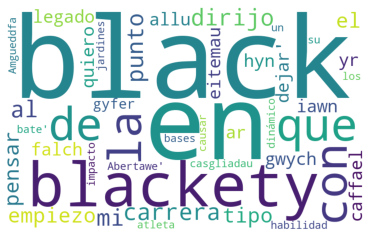

In [ ]:
results_to_filer = assess_group(4) 

Below there are the non-english quotes we found

In [ ]:
for q in df['quotation'].values[results_to_filer[1]][:4]:
  print(q)

Blackety-blackety-blackety-black, black black black black blackety-black...
Me dirijo al punto en mi carrera en que empiezo a pensar en el tipo de legado que quiero dejar
falch iawn o allu caffael yr eitemau gwych hyn ar gyfer casgliadau Amgueddfa Abertawe
atleta dinámico con la habilidad de causar un impacto en los jardines, en las bases y con su bate


Since the topics found are very "broad", we can refine our search by training a second LDA model on the quotes in a given topic, to find more specific **sub-topics**.

For instance, we train a model on the quotes in POLITICS to get the subtopics: "immigration", "environment", "taxes", etc.